In [1]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

#always forget to do this for better looking plots
import seaborn
seaborn.set()

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
from statsmodels.tsa import stattools
from sklearn import preprocessing
import random
import copy
import scipy
import sklearn.metrics
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

#energyplus processing functions
from eplusprocessing import *

/home/chase/applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
class linear_nnet(nn.Module):
    #linear model for kernelized inputs
    def __init__(self, params):
        super(linear_nnet, self).__init__()
        self.D_in = params['FEATURE_DIM']
        self.D_out = params['OUTPUT_DIM']
        self.l1 = nn.Linear(self.D_in, self.D_out)
    
    def forward(self, x):
        x = self.l1(x) #linear weights for model interpretability
        return(x)

In [4]:
#Bayesian classifier projection features
def mat_C(x):
    #x shape = px1
    C = np.dot(x, x.T) + np.eye(x.shape[0])
    return(C)

def mat_D(x, y, A):
    #x shape px1, y shape nx1, A nxp
    D = np.dot(y, x.T) + A
    return(D)

def likelihood_point(x, y, A):
    C = mat_C(x)
    D = mat_D(x, y, A)
    const = x.shape[0]*np.log(np.linalg.det(np.linalg.inv(C)))
    var = np.trace(y.dot(y.T) - 2*A.dot(x).dot(y.T) + x.T.dot(A.T).dot(A).dot(x))
    var2 = np.trace(y.dot(y.T) + A.dot(A.T) - D.dot(np.linalg.inv(C)).dot(D.T))   #mixed term doesn't look right
    out = var - var2 + const
    return(out)

In [5]:
#global vars
datapath = "/home/chase/projects/building_transfer/data/eplus_sims/"

#shared simulation var names
#dep_var_names = ['Electricity:Facility [J] !Hourly', 'Fans:Electricity [J] !Hourly', 'Cooling:Electricity [J] !Hourly']
dep_var_names = ['Fans:Electricity [J] !Hourly']
ind_var_names = ['EnvironmentSite Outdoor Air Drybulb Temperature [C] !Hourly', 'EnvironmentSite Outdoor Air Relative Humidity [%] !Hourly']#, 'DayType']

poly_degree = 3 #5 is optimal with full order 26 from cross validation
order = 6

### Train A on full year, assume true A

Train A on the full year, assume true A, learn decision boundary. Transfer A with small # of samples. Train new decision boundary with those samples + transfered A. Test.

In [6]:
#building specific var names

zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array(datapath + "refbuild_med/seattle/RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

In [7]:
X_train_pre, Y_train_pre, X_val_pre, Y_val_pre = split_train_val(Z, X, U, order=order, shuff=False, split_prop=1.0)
X_train, Y_train = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)
X_val, Y_val = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)

#kernelize
X_train_poly = polynomial_kernel_mat(X_train, poly_degree)
X_val_poly = polynomial_kernel_mat(X_val, poly_degree)

params = {'FEATURE_DIM': X_val_poly.shape[0], 'OUTPUT_DIM': Y_val_pre.shape[0]}
net = linear_nnet(params)
loss_func = nn.MSELoss()#SmoothL1Loss()
optimizer = optim.SGD(net.parameters(),lr=0.01, momentum=0.9)
epochs = 1000
batch_size = 100

for e in range(epochs):
    training_losses = []
    X_train_list, Y_train_list = minibatch_X_Y_arrays(X_train_poly, Y_train, batch_size)
    for i in enumerate(X_train_list):
        inp = Variable(torch.Tensor(X_train_list[i[0]].T))
        label = Variable(torch.Tensor(Y_train_list[i[0]].T))

        out = net(inp)
        optimizer.zero_grad()
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()

inp_val = Variable(torch.Tensor(X_val_poly.T))
label_val = Variable(torch.Tensor(Y_val.T))
out_val = net(inp_val)
loss_val = loss_func(out_val, label_val)
print("Validation MSE: ", loss_val)

Validation MSE:  tensor(0.0027, grad_fn=<MseLossBackward>)


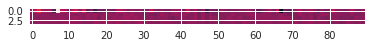

In [8]:
A = copy.copy(net.l1.weight.data.numpy())
plt.imshow(A)
plt.show()

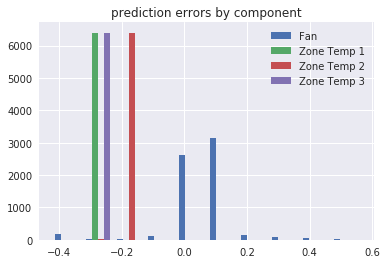

In [9]:
#plot the distribution of the forecast error
errs = []
for i in range(X_val_poly.shape[1]-1): 
    errs.append(A.dot(X_val_poly[:,i]) - Y_val[:,i])
    
plt.hist(np.asarray(errs), bins=10, label=["Fan", "Zone Temp 1", "Zone Temp 2", "Zone Temp 3"])
plt.title("prediction errors by component")
plt.legend()
plt.show()

In [10]:
zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array(datapath + "refbuild_med/seattle/RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_all_pre, Y_all_pre, X_v, Y_v = split_train_val(Z, X, U, order=order, shuff=False, split_prop=1.0)
X_all, Y_all = normalize_data_set(X_all_pre, Y_all_pre, X_all_pre)

#kernelize
X_all_poly = polynomial_kernel_mat(X_all, poly_degree)

In [11]:
zone_temp_inds = [863,864,865]

Z_f, X_f, U_f = read_total_data_array(datapath + "refbuild_med_airfault/seattle/Fault_FoulingAirFilter_RefBldgMediumOfficeNew2004.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_all_pre_f, Y_all_pre_f, X_v_f, Y_v_f = split_train_val(Z_f, X_f, U_f, order=order, shuff=False, split_prop=1.0)
X_all_f, Y_all_f = normalize_data_set(X_all_pre_f, Y_all_pre_f, X_all_pre)

#kernelize
X_all_poly_f = polynomial_kernel_mat(X_all_f, poly_degree)

In [12]:
#use inputs to classification rule as features; try logistic regression classifier

#use features from log-likelihood classifier

X = []
Y = []

for i in range(X_all_poly.shape[1]):
    if i % 1000 == 0:
        print("No fault data: ", np.around(100*(i/X_all_poly.shape[1])), "%")
    x = np.expand_dims(X_all_poly[:,i], axis=1)
    y = np.expand_dims(Y_all[:,i], axis=1)
    C = mat_C(x)
    D = mat_D(x, y, A)
    C_inv = np.linalg.inv(C)
    term1 = x.shape[0]*np.log(np.linalg.det(C_inv))
    term2 = np.trace(C_inv.dot(D.T).dot(D))
    term3 = -1.0*np.trace(A.dot(A.T))
    term4 = -2.0*np.trace(A.dot(x).dot(y.T))
    term5 = np.trace(x.T.dot(A.T).dot(A).dot(x))

    feat = [term1, term2, term3, term4, term5]
    features_app = np.asarray(feat)#(feat + list(x[:,0]) + list(y[:,0])) #np.expand_dims(A.flatten(), axis=1), x and y themselves seem to be a waste
    X.append(features_app)
    Y.append(0)
    
for i in range(X_all_poly_f.shape[1]):
    if i % 1000 == 0:
        print("Fault data: ", np.around(100*(i/X_all_poly.shape[1])), "%")
    x = np.expand_dims(X_all_poly_f[:,i], axis=1) #tried with fault data, using normal operational data
    y = np.expand_dims(Y_all_f[:,i], axis=1)
    C = mat_C(x)
    D = mat_D(x, y, A)
    C_inv = np.linalg.inv(C)
    term1 = x.shape[0]*np.log(np.linalg.det(C_inv))
    term2 = np.trace(C_inv.dot(D.T).dot(D))
    term3 = -1.0*np.trace(A.dot(A.T))
    term4 = -2.0*np.trace(A.dot(x).dot(y.T))
    term5 = np.trace(x.T.dot(A.T).dot(A).dot(x))

    feat = [term1, term2, term3, term4, term5]
    features_app = np.asarray(feat)#(feat + list(x[:,0]) + list(y[:,0])) #np.expand_dims(A.flatten(), axis=1)
    X.append(features_app)
    Y.append(1)
    
X = np.asarray(X)
Y = np.asarray(Y)

No fault data:  0.0 %
No fault data:  16.0 %
No fault data:  31.0 %
No fault data:  47.0 %
No fault data:  62.0 %
No fault data:  78.0 %
No fault data:  94.0 %
Fault data:  0.0 %
Fault data:  16.0 %
Fault data:  31.0 %
Fault data:  47.0 %
Fault data:  62.0 %
Fault data:  78.0 %
Fault data:  94.0 %


In [13]:
Y = np.expand_dims(Y, axis=1)
X = X.T
Y = Y.T

#Y = np.asarray(Y)
#X = np.asarray(X.T)

print(X.shape, Y.shape)

(5, 12802) (1, 12802)


In [14]:
#reformat for sklearn 

nofault_samps = []
fault_samps = []

for i in range(X.shape[1]):
    if Y[0,i] == 0:
        nofault_samps.append(X[:,i])
    else:
        fault_samps.append(X[:,i])
        
        
lag = 75

X_lag_nf = np.zeros((lag*X.shape[0], len(nofault_samps) - lag))
Y_lag_nf = np.zeros((1, len(nofault_samps) - lag))

X_lag_f = np.zeros((lag*X.shape[0], len(fault_samps) - lag))
Y_lag_f = np.ones((1, len(fault_samps) - lag))

for i in range(len(nofault_samps)-lag):
    samps = []
    for j in range(lag):
        samps.append(nofault_samps[i + j])
    X_lag_nf[:,i] = np.asarray(samps).flatten()
    
for i in range(len(fault_samps)-lag):
    samps = []
    for j in range(lag):
        samps.append(fault_samps[i + j])
    X_lag_f[:,i] = np.asarray(samps).flatten()
    
X = np.hstack((X_lag_nf, X_lag_f))
Y = np.concatenate((Y_lag_nf, Y_lag_f), axis=1)

In [ ]:
#shuffle and train/val split

train_vals = np.random.choice(X.shape[1], int(0.8*X.shape[1]), replace=False)
vals = np.asarray([ i for i in range(X.shape[1]) if i not in train_vals ])

X_train_log_reg = X[:,train_vals] #X[:,train_vals]
Y_train_log_reg = Y[:,train_vals]

X_val_log_reg = X[:,vals]
Y_val_log_reg = Y[:,vals]

In [ ]:
#train logistic regression classifier for fault/no fault

logreg_model_obj = LogisticRegression(tol=0.0001, C=0.9, max_iter=10000, verbose=1)#, n_jobs=-1, solver="saga")
logreg_model_obj.fit(X_train_log_reg.T, Y_train_log_reg.T)

Y_hat = logreg_model_obj.predict(X_train_log_reg.T)

p = sklearn.metrics.precision_score(Y_train_log_reg.T, Y_hat.T)
r = sklearn.metrics.recall_score(Y_train_log_reg.T, Y_hat.T)

print("Training precision: ", p)
print("Training recall: ", r)

Y_hat_val = logreg_model_obj.predict(X_val_log_reg.T)

p = sklearn.metrics.precision_score(Y_val_log_reg.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_log_reg.T, Y_hat_val.T)

print("Validation precision: ", p)
print("Validation recall: ", r)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]

In [ ]:
#classify a elements of a sequence, +1 if fault, -1 if no fault, signal according to polling

fault_votes = [0.0]
nofault_votes = [0.0]
base = [0.0]

for i in range(X_val_log_reg.shape[1]):
    #if no fault
    if Y_val_log_reg[0,i] == 0:
        Y_hat = logreg_model_obj.predict(X_val_log_reg[:,i].T.reshape(1, -1))
        if Y_hat == 0:
            nofault_votes.append(nofault_votes[-1] - 1)
        if Y_hat == 1:
            nofault_votes.append(nofault_votes[-1] + 1)
    #if fault
    if Y_val_log_reg[0,i] == 1:
        Y_hat = logreg_model_obj.predict(X_val_log_reg[:,i].T.reshape(1, -1))
        if Y_hat == 0:
            fault_votes.append(fault_votes[-1] - 1)
        if Y_hat == 1:
            fault_votes.append(fault_votes[-1] + 1)
        base.append(base[-1] + 0.5)

In [ ]:
plt.plot(fault_votes, label="fault data")
plt.plot(nofault_votes, label="no fault data")
plt.plot(base, label="1/2")
plt.plot(np.zeros((len(fault_votes,))))
plt.ylabel("net positive fault classifications")
plt.xlabel("number of samples")
plt.title("logistic regression classifier performance")
plt.legend()
plt.show()

In [ ]:
logreg_model

### Transfer from Summer to Winter w/ single building, single climate

In [ ]:
shift=168  #just to get it away from the extreme ends of the seasons
season_i = [0+shift, 1595+shift, 2*1595+shift, 3*1595+shift]

In [48]:
#train initial for 2 weeks in winter
horizon = 168*2
start_i = 0+shift

params = {'FEATURE_DIM': X_val_poly.shape[0], 'OUTPUT_DIM': Y_val_pre.shape[0]}
winter_net = linear_nnet(params)
loss_func = nn.MSELoss()
optimizer = optim.SGD(winter_net.parameters(),lr=0.01, momentum=0.9)
epochs = 200
batch_size = 24           #this parameter seems to matter alot
training_losses = []

#train the winter transition matrix
X_train_s = X_all_poly[:,0+shift:0+shift+horizon]
Y_train_s = Y_all[:,0+shift:0+shift+horizon]

for e in range(epochs):
    training_losses = []
    X_train_list, Y_train_list = minibatch_X_Y_arrays(X_train_s, Y_train_s, batch_size)
    for i in enumerate(X_train_list):
        inp = Variable(torch.Tensor(X_train_list[i[0]].T))
        label = Variable(torch.Tensor(Y_train_list[i[0]].T))

        out = winter_net(inp)
        optimizer.zero_grad()
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.data.item())
        
torch.save(winter_net, "winter_net.torch")

all_val_inds = np.arange(2*1594,3*1594,1)  #get all summer values
X_val_s = X_all_poly[:,all_val_inds]
Y_val_s = Y_all[:,all_val_inds]

validation_loss_transfer = []
validation_mape_transfer = []

num_hours = []

for s in range(25,horizon):
    num_hours.append(s + order)
    if s % 10 == 0:
        print("Training data size: ", s)
        
    params = {'FEATURE_DIM': X_val_poly.shape[0], 'OUTPUT_DIM': Y_val_pre.shape[0]}
    transfer_net = torch.load("winter_net.torch")
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(transfer_net.parameters(),lr=0.01, momentum=0.9)
    epochs = 200
    batch_size = 24           #this parameter seems to matter alot
    training_losses = []
        
    X_train_summer = X_all_poly[:,2*1594+shift:2*1594+shift+s]  #get summer training data
    Y_train_summer = Y_all[:,2*1594+shift:2*1594+shift+s]

    for e in range(epochs):
        training_losses = []
        X_train_list, Y_train_list = minibatch_X_Y_arrays(X_train_summer, Y_train_summer, batch_size)
        for i in enumerate(X_train_list):
            inp = Variable(torch.Tensor(X_train_list[i[0]].T))
            label = Variable(torch.Tensor(Y_train_list[i[0]].T))

            out = transfer_net(inp)
            optimizer.zero_grad()
            loss = loss_func(out, label)
            loss.backward()
            optimizer.step()
            training_losses.append(loss.data.item())

    inp_val = Variable(torch.Tensor(X_val_s.T))
    label_val = Variable(torch.Tensor(Y_val_s.T))
    out_val = transfer_net(inp_val)
    loss_val = loss_func(out_val, label_val)
    validation_loss_transfer.append(loss_val.item())
    validation_mape_transfer.append(torch.mean(torch.abs(out_val - label_val)/label_val).item())

/home/chase/applications/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type linear_nnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Training data size:  30
Training data size:  40
Training data size:  50
Training data size:  60
Training data size:  70
Training data size:  80
Training data size:  90
Training data size:  100
Training data size:  110
Training data size:  120
Training data size:  130
Training data size:  140
Training data size:  150
Training data size:  160
Training data size:  170
Training data size:  180
Training data size:  190
Training data size:  200
Training data size:  210
Training data size:  220
Training data size:  230
Training data size:  240
Training data size:  250
Training data size:  260
Training data size:  270
Training data size:  280
Training data size:  290
Training data size:  300
Training data size:  310
Training data size:  320
Training data size:  330


In [50]:
#set "inital" as random, train and validate in summer
shift=168
horizon = 168*2
start_i = 0+shift

validation_loss_random = []
validation_mape_random = []

for s in range(25,horizon):
    num_hours.append(s + order)
    if s % 10 == 0:
        print("Training data size: ", s)
        
    params = {'FEATURE_DIM': X_val_poly.shape[0], 'OUTPUT_DIM': Y_val_pre.shape[0]}
    random_net = linear_nnet(params)
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(random_net.parameters(),lr=0.01, momentum=0.9)
    epochs = 200
    batch_size = 24           #this parameter seems to matter alot
    training_losses = []
        
    X_train_summer = X_all_poly[:,2*1594+shift:2*1594+shift+s]  #get summer training data
    Y_train_summer = Y_all[:,2*1594+shift:2*1594+shift+s]

    for e in range(epochs):
        training_losses = []
        X_train_list, Y_train_list = minibatch_X_Y_arrays(X_train_summer, Y_train_summer, batch_size)
        for i in enumerate(X_train_list):
            inp = Variable(torch.Tensor(X_train_list[i[0]].T))
            label = Variable(torch.Tensor(Y_train_list[i[0]].T))

            out = random_net(inp)
            optimizer.zero_grad()
            loss = loss_func(out, label)
            loss.backward()
            optimizer.step()
            training_losses.append(loss.data.item())

    inp_val = Variable(torch.Tensor(X_val_s.T))
    label_val = Variable(torch.Tensor(Y_val_s.T))
    out_val = random_net(inp_val)
    loss_val = loss_func(out_val, label_val)
    validation_loss_random.append(loss_val.item())
    validation_mape_random.append(torch.mean(torch.abs(out_val - label_val)/label_val).item())

Training data size:  30
Training data size:  40
Training data size:  50
Training data size:  60
Training data size:  70
Training data size:  80
Training data size:  90
Training data size:  100
Training data size:  110
Training data size:  120
Training data size:  130
Training data size:  140
Training data size:  150
Training data size:  160
Training data size:  170
Training data size:  180
Training data size:  190
Training data size:  200
Training data size:  210
Training data size:  220
Training data size:  230
Training data size:  240
Training data size:  250
Training data size:  260
Training data size:  270
Training data size:  280
Training data size:  290
Training data size:  300
Training data size:  310
Training data size:  320
Training data size:  330


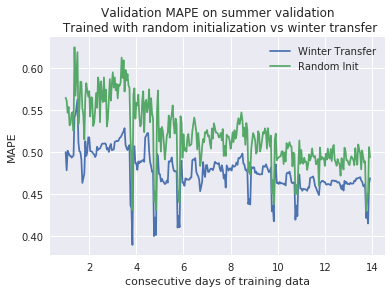

In [51]:
nh = np.asarray([float(i + 24) for i in range(len(validation_mape_transfer))])/24.0
plt.plot(nh, np.asarray(validation_mape_transfer), label="Winter Transfer")
plt.plot(nh, np.asarray(validation_mape_random), label="Random Init")
plt.legend()
plt.title("Validation MAPE on summer validation\n Trained with random initialization vs winter transfer")
plt.xlabel("consecutive days of training data")
plt.ylabel("MAPE")
plt.show()

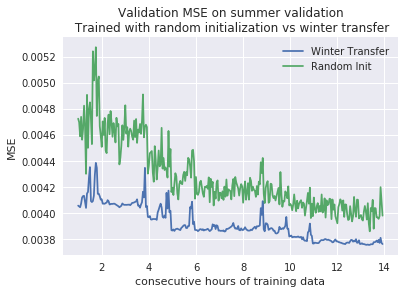

In [52]:
plt.plot(nh, np.asarray(validation_loss_transfer), label="Winter Transfer")
plt.plot(nh, np.asarray(validation_loss_random), label="Random Init")
plt.legend()
plt.title("Validation MSE on summer validation\n Trained with random initialization vs winter transfer")
plt.xlabel("consecutive hours of training data")
plt.ylabel("MSE")
plt.show()

In [53]:
#load state transition matrix

net = torch.load("winter_net.torch")
A = copy.copy(net.l1.weight.data.numpy())

#use new A to generate features

In [57]:
#use inputs to classification rule as features; try logistic regression classifier

#use features from log-likelihood classifier

X = []
Y = []

#extend horizon to get some validation data
horizon = 4*168

#user winter data
X_train_s = X_all_poly[:,0+shift:0+shift+horizon]
Y_train_s = Y_all[:,0+shift:0+shift+horizon]

X_train_s_f = X_all_poly_f[:,0+shift:0+shift+horizon]
Y_train_s_f = Y_all_f[:,0+shift:0+shift+horizon]

for i in range(X_train_s.shape[1]):
    if i % 10 == 0:
        print("No fault data: ", np.around(100*(i/X_train_s.shape[1])), "%")
    x = np.expand_dims(X_train_s[:,i], axis=1)
    y = np.expand_dims(Y_train_s[:,i], axis=1)
    C = mat_C(x)
    D = mat_D(x, y, A)
    C_inv = np.linalg.inv(C)
    term1 = x.shape[0]*np.log(np.linalg.det(C_inv))
    term2 = np.trace(C_inv.dot(D.T).dot(D))
    term3 = -1.0*np.trace(A.dot(A.T))
    term4 = -2.0*np.trace(A.dot(x).dot(y.T))
    term5 = np.trace(x.T.dot(A.T).dot(A).dot(x))

    feat = [term1, term2, term3, term4, term5]
    features_app = np.asarray(feat)#(feat + list(x[:,0]) + list(y[:,0])) #np.expand_dims(A.flatten(), axis=1), x and y themselves seem to be a waste
    X.append(features_app)
    Y.append(0)
    
for i in range(X_train_s_f.shape[1]):
    if i % 10 == 0:
        print("Fault data: ", np.around(100*(i/X_train_s_f.shape[1])), "%")
    x = np.expand_dims(X_train_s_f[:,i], axis=1) #tried with fault data, using normal operational data
    y = np.expand_dims(Y_train_s_f[:,i], axis=1)
    C = mat_C(x)
    D = mat_D(x, y, A)
    C_inv = np.linalg.inv(C)
    term1 = x.shape[0]*np.log(np.linalg.det(C_inv))
    term2 = np.trace(C_inv.dot(D.T).dot(D))
    term3 = -1.0*np.trace(A.dot(A.T))
    term4 = -2.0*np.trace(A.dot(x).dot(y.T))
    term5 = np.trace(x.T.dot(A.T).dot(A).dot(x))

    feat = [term1, term2, term3, term4, term5]
    features_app = np.asarray(feat)#(feat + list(x[:,0]) + list(y[:,0])) #np.expand_dims(A.flatten(), axis=1)
    X.append(features_app)
    Y.append(1)
    
X = np.asarray(X)
Y = np.asarray(Y)
Y = np.expand_dims(Y, axis=1)
X = X.T
Y = Y.T


nofault_samps = []
fault_samps = []

for i in range(X.shape[1]):
    if Y[0,i] == 0:
        nofault_samps.append(X[:,i])
    else:
        fault_samps.append(X[:,i])
        
        
lag = 100

X_lag_nf = np.zeros((lag*X.shape[0], len(nofault_samps) - lag))
Y_lag_nf = np.zeros((1, len(nofault_samps) - lag))

X_lag_f = np.zeros((lag*X.shape[0], len(fault_samps) - lag))
Y_lag_f = np.ones((1, len(fault_samps) - lag))

for i in range(len(nofault_samps)-lag):
    samps = []
    for j in range(lag):
        samps.append(nofault_samps[i + j])
    X_lag_nf[:,i] = np.asarray(samps).flatten()
    
for i in range(len(fault_samps)-lag):
    samps = []
    for j in range(lag):
        samps.append(fault_samps[i + j])
    X_lag_f[:,i] = np.asarray(samps).flatten()
    
X = np.hstack((X_lag_nf, X_lag_f))
Y = np.concatenate((Y_lag_nf, Y_lag_f), axis=1)

No fault data:  0.0 %
No fault data:  1.0 %
No fault data:  3.0 %
No fault data:  4.0 %
No fault data:  6.0 %
No fault data:  7.0 %
No fault data:  9.0 %
No fault data:  10.0 %
No fault data:  12.0 %
No fault data:  13.0 %
No fault data:  15.0 %
No fault data:  16.0 %
No fault data:  18.0 %
No fault data:  19.0 %
No fault data:  21.0 %
No fault data:  22.0 %
No fault data:  24.0 %
No fault data:  25.0 %
No fault data:  27.0 %
No fault data:  28.0 %
No fault data:  30.0 %
No fault data:  31.0 %
No fault data:  33.0 %
No fault data:  34.0 %
No fault data:  36.0 %
No fault data:  37.0 %
No fault data:  39.0 %
No fault data:  40.0 %
No fault data:  42.0 %
No fault data:  43.0 %
No fault data:  45.0 %
No fault data:  46.0 %
No fault data:  48.0 %
No fault data:  49.0 %
No fault data:  51.0 %
No fault data:  52.0 %
No fault data:  54.0 %
No fault data:  55.0 %
No fault data:  57.0 %
No fault data:  58.0 %
No fault data:  60.0 %
No fault data:  61.0 %
No fault data:  62.0 %
No fault data:  64

In [58]:
X.shape, Y.shape

((500, 1144), (1, 1144))

In [59]:
#shuffle and train/val split

train_vals = np.random.choice(X.shape[1], int(0.8*X.shape[1]), replace=False)
vals = np.asarray([ i for i in range(X.shape[1]) if i not in train_vals ])

X_train_log_reg = X[:,train_vals] #X[:,train_vals]
Y_train_log_reg = Y[:,train_vals]

X_val_log_reg = X[:,vals]
Y_val_log_reg = Y[:,vals]

In [60]:
#test previously trained logisitc regression model on current features

Y_hat_val = logreg_model_obj.predict(X_val_log_reg.T)

p = sklearn.metrics.precision_score(Y_val_log_reg.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_log_reg.T, Y_hat_val.T)

print("Validation precision: ", p)
print("Validation recall: ", r)

#classify a elements of a sequence, +1 if fault, -1 if no fault, signal according to polling

fault_votes = [0.0]
nofault_votes = [0.0]
base = [0.0]

for i in range(X_val_log_reg.shape[1]):
    #if no fault
    if Y_val_log_reg[0,i] == 0:
        Y_hat = logreg_model_obj.predict(X_val_log_reg[:,i].T.reshape(1, -1))
        if Y_hat == 0:
            nofault_votes.append(nofault_votes[-1] - 1)
        if Y_hat == 1:
            nofault_votes.append(nofault_votes[-1] + 1)
    #if fault
    if Y_val_log_reg[0,i] == 1:
        Y_hat = logreg_model_obj.predict(X_val_log_reg[:,i].T.reshape(1, -1))
        if Y_hat == 0:
            fault_votes.append(fault_votes[-1] - 1)
        if Y_hat == 1:
            fault_votes.append(fault_votes[-1] + 1)
        base.append(base[-1] + 0.5)
        
plt.plot(fault_votes, label="fault data")
plt.plot(nofault_votes, label="no fault data")
plt.plot(base, label="1/2")
plt.plot(np.zeros((len(fault_votes,))))
plt.ylabel("net positive fault classifications")
plt.xlabel("number of samples")
plt.title("logistic regression classifier performance")
plt.legend()
plt.show()

NotFittedError: This LogisticRegression instance is not fitted yet

In [ ]:
#transfer  logistic regression classifier for fault/no fault
logreg_model_obj = LogisticRegression(tol=0.0001, C=0.9, max_iter=10000, verbose=1, warm_start=True)#, n_jobs=-1, solver="saga")
logreg_model_obj.fit(X_train_log_reg.T, Y_train_log_reg.T)

Y_hat = logreg_model_obj.predict(X_train_log_reg.T)

p = sklearn.metrics.precision_score(Y_train_log_reg.T, Y_hat.T)
r = sklearn.metrics.recall_score(Y_train_log_reg.T, Y_hat.T)

print("Training precision: ", p)
print("Training recall: ", r)


In [ ]:
#transfer to Phoenix